## Time Series Sales Prediction with FBProphet

Kaggle's Rossmann Sales Competition. Aim is to predict store sales. More info <a href="https://www.kaggle.com/c/rossmann-store-sales/overview">here.</a>

### Table of Contents

1. [Imports](#Imports)    
2. [Data](#Data)  
3. [EDA](#EDA)    
4. [Forecasts](#Forecasts)  

### Imports

In [1]:
# main
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle
import random

# datetimes
import datetime as dt
from datetime import datetime
import time

# dataviz
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# plot style
%config InteractiveShellApp.pylab_import_all = False
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7)

plt.style.use('seaborn-colorblind')

# outline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%precision %.3f

# pandas display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import data
df = pd.read_csv("../data/rossmann-store-sales/train.csv",parse_dates = True,index_col = 'Date')
df['Date'] = df.index
# not importing test set, as there's no need for predictions covered in this notebook
store = pd.read_csv("../data/rossmann-store-sales/store.csv",index_col = 'Store')

### Data

In [3]:
len(df)
len(store)

1017209

1115

In [4]:
df.describe()
df.info()
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Sales          1017209 non-null  int64         
 3   Customers      1017209 non-null  int64         
 4   Open           1017209 non-null  int64         
 5   Promo          1017209 non-null  int64         
 6   StateHoliday   1017209 non-null  object        
 7   SchoolHoliday  1017209 non-null  int64         
 8   Date           1017209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 77.6+ MB


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date
Date,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015-07-31
2015-07-31,2,5,6064,625,1,1,0,1,2015-07-31
2015-07-31,3,5,8314,821,1,1,0,1,2015-07-31
2015-07-31,4,5,13995,1498,1,1,0,1,2015-07-31
2015-07-31,5,5,4822,559,1,1,0,1,2015-07-31


In [5]:
# some new columns for time series analysis
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [6]:
# missing values
df.isna().mean()
store.isna().mean()

Store            0.0
DayOfWeek        0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
Date             0.0
Year             0.0
Month            0.0
Day              0.0
dtype: float64

StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [7]:
# closed stores
len(df[(df.Open == 0) & (df.Sales == 0)])
df[(df.Open == 0) & (df.Sales == 0)]['Store'].nunique()

172817

1105

In [8]:
# open but no sales
len(df[(df.Open != 0) & (df.Sales == 0)])
df[(df.Open != 0) & (df.Sales == 0)]['Store'].nunique()

54

41

In [9]:
# got rid of the above - these won't be used in prediction after all
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

In [10]:
store.head()

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,
1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
# fill missing values in store
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
store.fillna(0, inplace = True) # the rest

In [12]:
# join train and store since store has some values we want to have a look at
df = pd.merge(df,store,how = 'inner',on = 'Store',right_index=True)
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date,Year,Month,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015-07-31,2015,7,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-30,1,4,5020,546,1,1,0,1,2015-07-30,2015,7,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-29,1,3,4782,523,1,1,0,1,2015-07-29,2015,7,29,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-28,1,2,5011,560,1,1,0,1,2015-07-28,2015,7,28,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-27,1,1,6102,612,1,1,0,1,2015-07-27,2015,7,27,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### EDA

In [13]:
# Stores Types
df.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


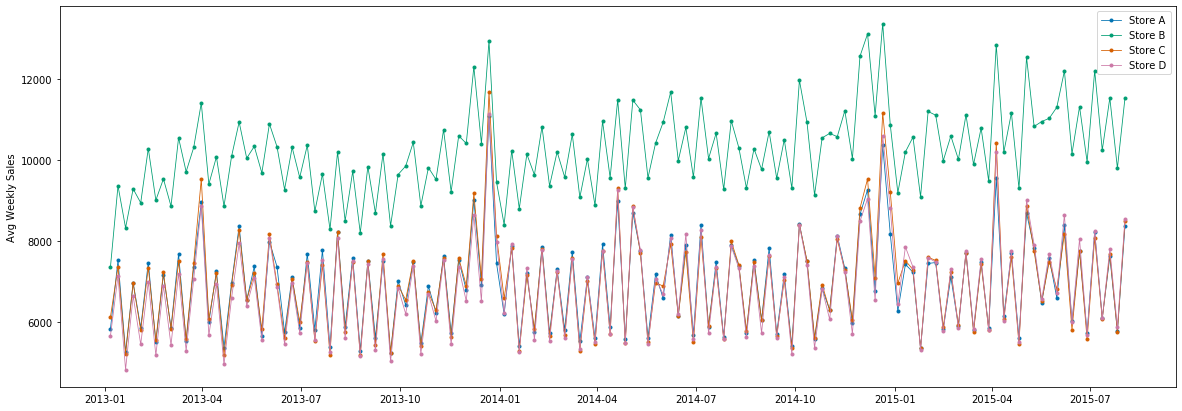

In [14]:
# Sales by Store (Average Weekly Sales)
train_a_weekly_mean = df[df.StoreType=='a']['Sales'].resample('W').mean()
train_b_weekly_mean = df[df.StoreType=='b']['Sales'].resample('W').mean()
train_c_weekly_mean = df[df.StoreType=='c']['Sales'].resample('W').mean()
train_d_weekly_mean = df[df.StoreType=='d']['Sales'].resample('W').mean()

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(train_a_weekly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store A')
ax.plot(train_b_weekly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store B')
ax.plot(train_c_weekly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store C')
ax.plot(train_d_weekly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store D')

ax.set_ylabel('Avg Weekly Sales')
ax.legend();

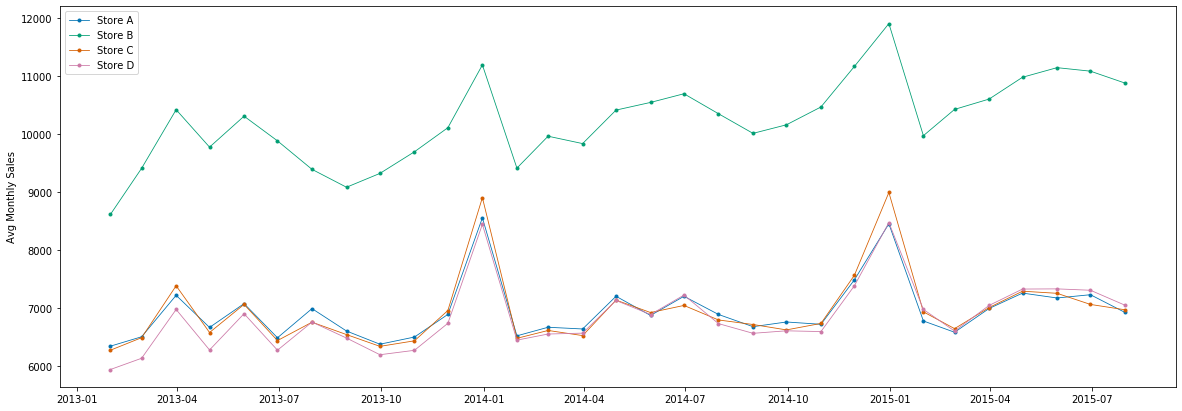

In [15]:
# Sales by Store (Average Monthly Sales)
train_a_monthly_mean = df[df.StoreType=='a']['Sales'].resample('M').mean()
train_b_monthly_mean = df[df.StoreType=='b']['Sales'].resample('M').mean()
train_c_monthly_mean = df[df.StoreType=='c']['Sales'].resample('M').mean()
train_d_monthly_mean = df[df.StoreType=='d']['Sales'].resample('M').mean()

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(train_a_monthly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store A')
ax.plot(train_b_monthly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store B')
ax.plot(train_c_monthly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store C')
ax.plot(train_d_monthly_mean,marker='.',linestyle='-',linewidth=0.8,label='Store D')

ax.set_ylabel('Avg Monthly Sales')
ax.legend();

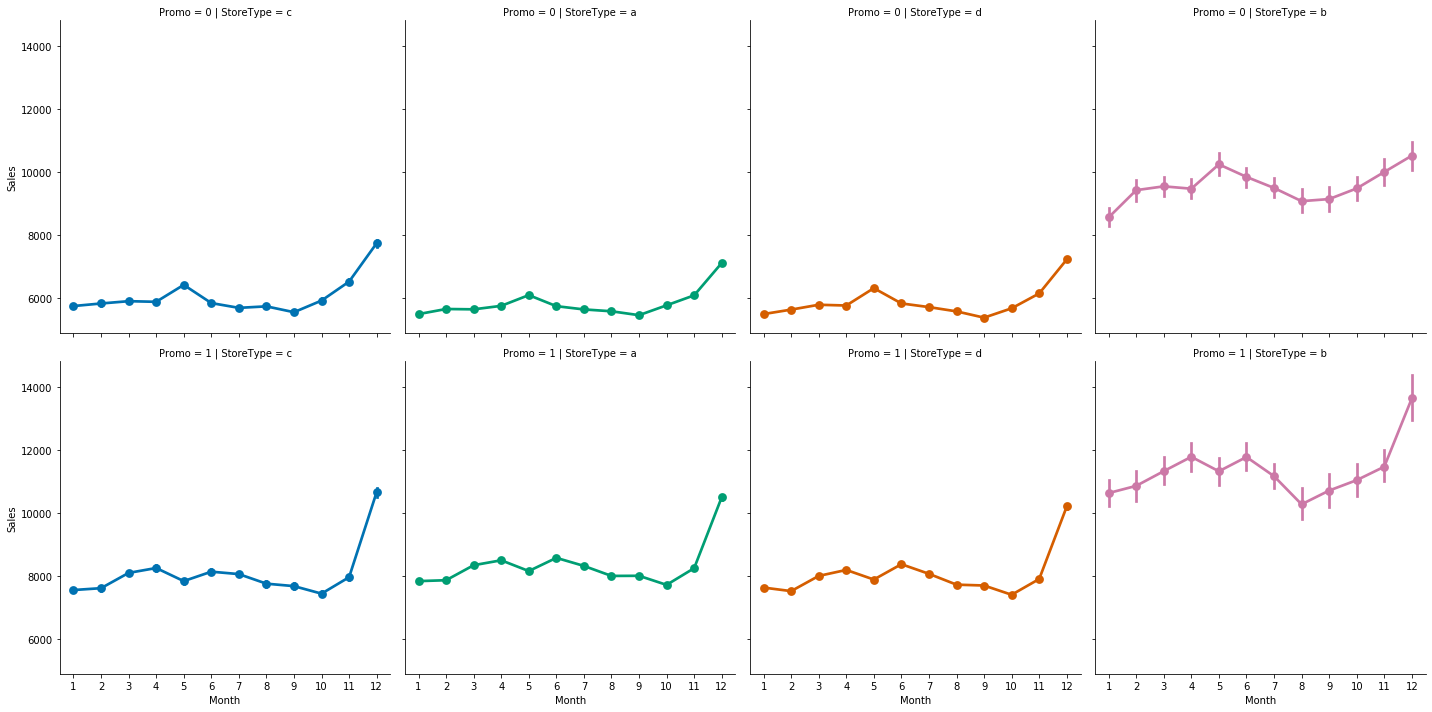

In [16]:
# Promos
sns.factorplot(x='Month',y='Sales',data=df,col='StoreType',hue='StoreType',row='Promo') 

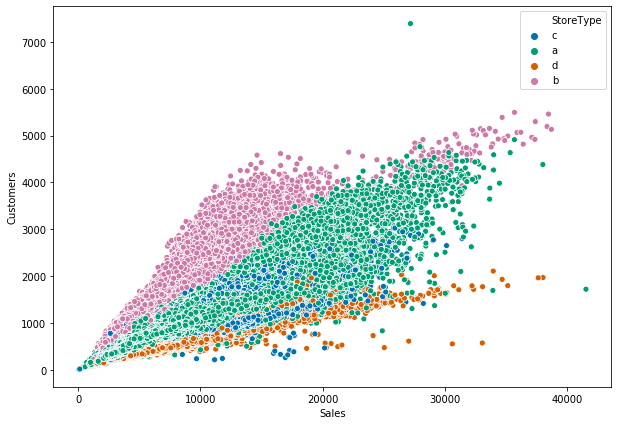

In [17]:
# Customers vs Sales
sns.scatterplot(x='Sales',y='Customers',data=df,hue='StoreType')

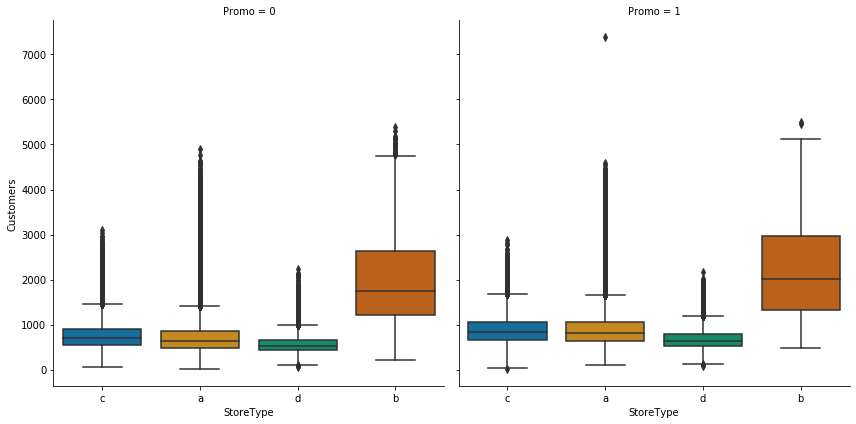

In [18]:
# Customers vs Promo
g = sns.FacetGrid(df,col='Promo',height=6,aspect=1)
g = g.map(sns.boxplot,'StoreType','Customers',palette='colorblind')

### Forecasts

Text(0.5, 1.0, 'Store: A')

Text(0.5, 0, 'Date')

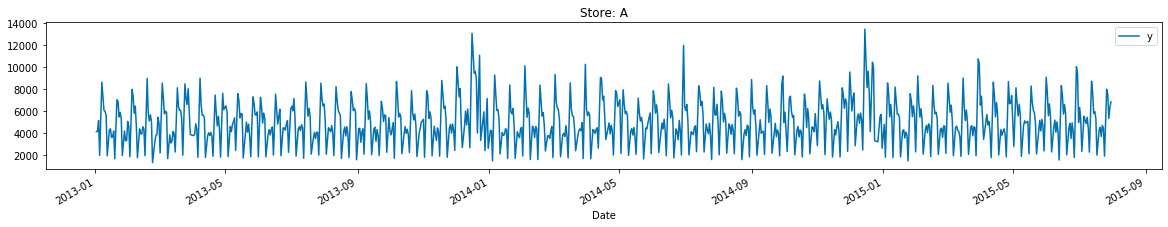

Text(0.5, 1.0, 'Store: B')

Text(0.5, 0, 'Date')

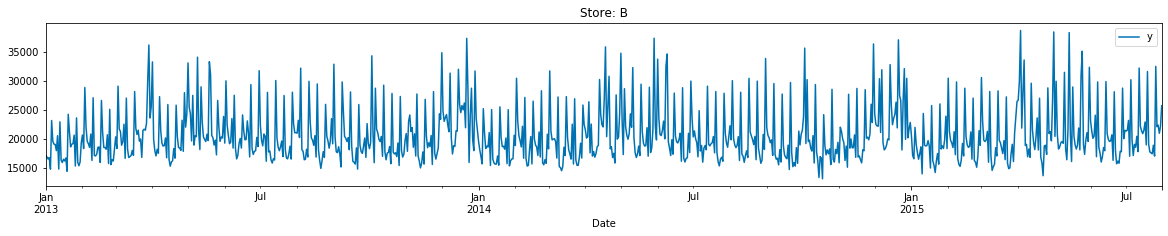

Text(0.5, 1.0, 'Store: C')

Text(0.5, 0, 'Date')

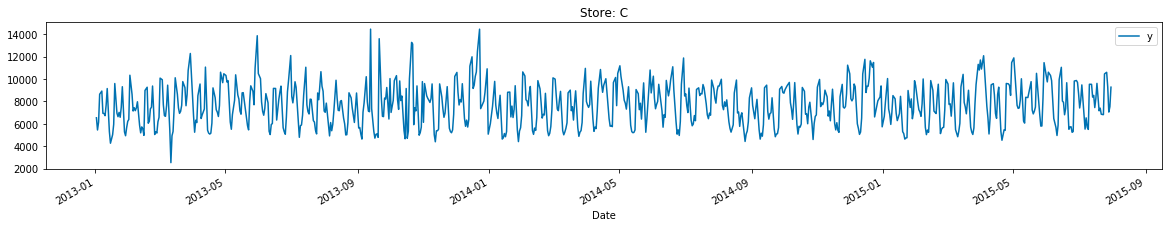

Text(0.5, 1.0, 'Store: D')

Text(0.5, 0, 'Date')

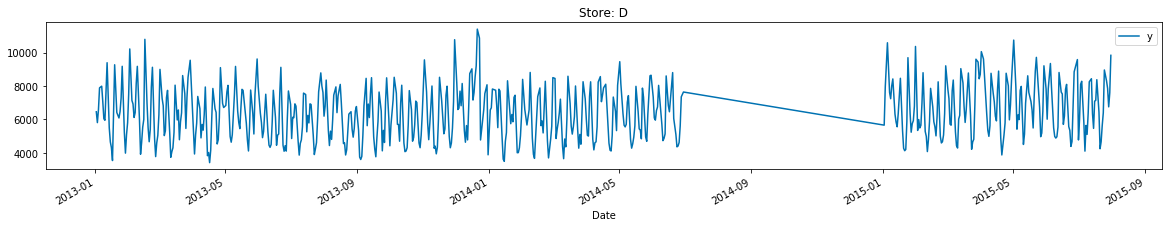

In [19]:
# select random stores for each StoreType
stores = {}
dfs = {}
for x in ['a','b','c','d']:
    stores[x]=random.choice(df[df.StoreType==x]['Store'].unique())
    dfs[x]=df[df.Store==stores[x]]['Sales']
    dfs[x]=dfs[x].reset_index()
    dfs[x]=dfs[x].rename(columns ={'Date': 'ds','Sales': 'y'})
    dfs[x].sort_values(by='ds',inplace=True)
    
    # plot time series
    ax=dfs[x].set_index('ds').plot(figsize = (20, 3))
    ax.set_title('Store: '+str(x).upper())
    ax.set_xlabel('Date')
    plt.show()
    

In [20]:
# Prophet
from fbprophet import Prophet

# set up holidays
h = {}
for x in ['a','b','c','d']:
    state_h = df[(df.StateHoliday==x)].loc[:, 'Date'].values
    school_h = df[(df.SchoolHoliday==1)&(df.StoreType==x)].loc[:, 'Date'].values
    h[x] = pd.concat((pd.DataFrame({'ds': pd.to_datetime(state_h),'holiday': 'state'}),
                     pd.DataFrame({'ds': pd.to_datetime(school_h),'holiday': 'school'})))      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Store: A')

Text(0.5, 1, 'Store: A')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Store: B')

Text(0.5, 1, 'Store: B')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Store: C')

Text(0.5, 1, 'Store: C')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Store: D')

Text(0.5, 1, 'Store: D')

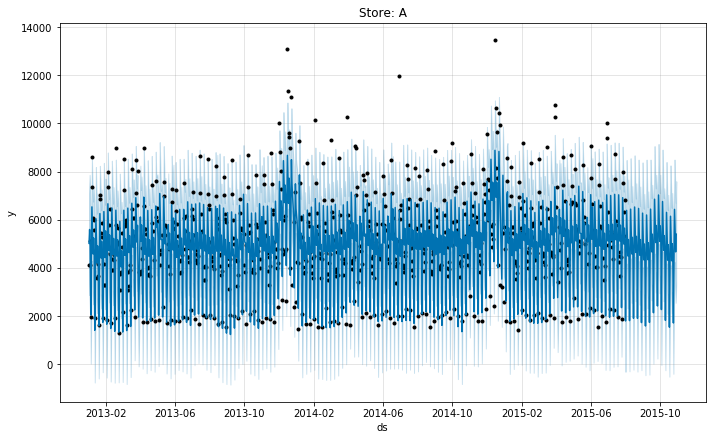

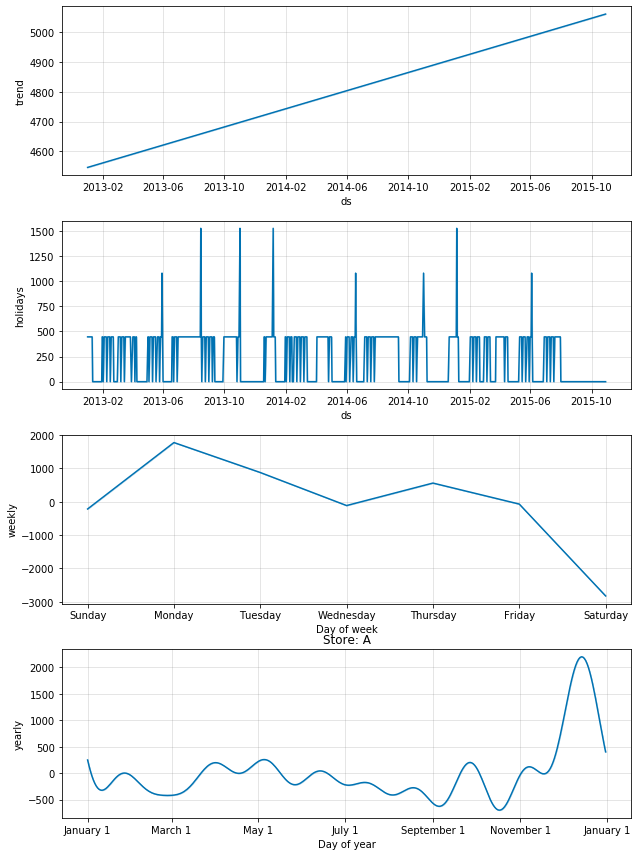

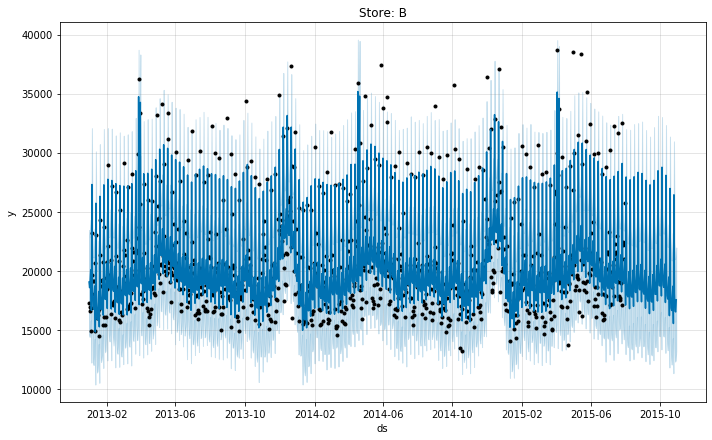

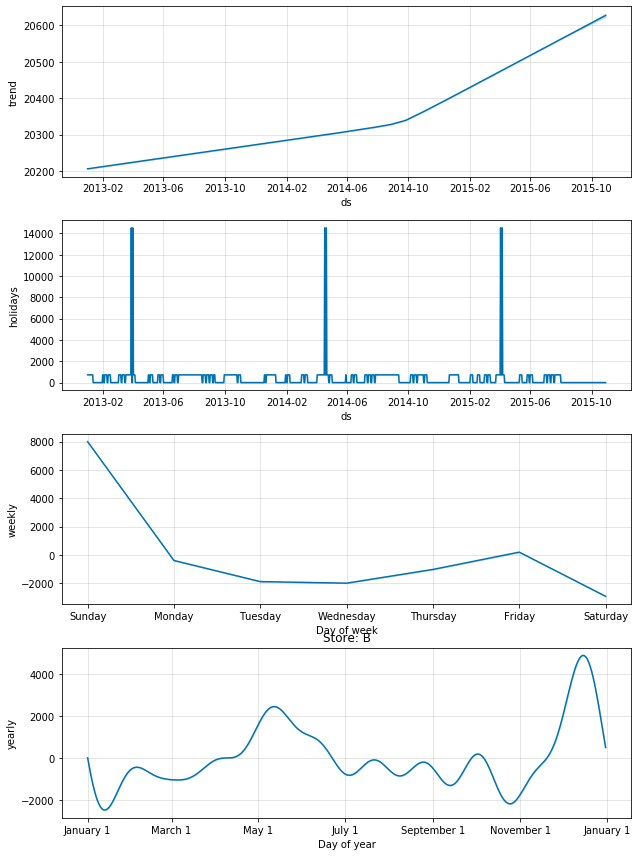

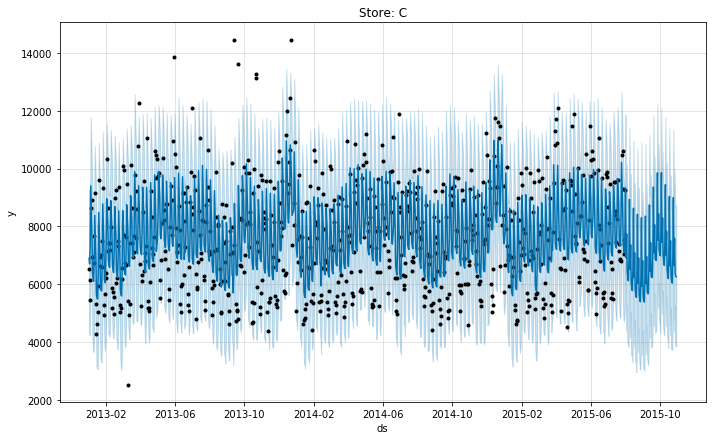

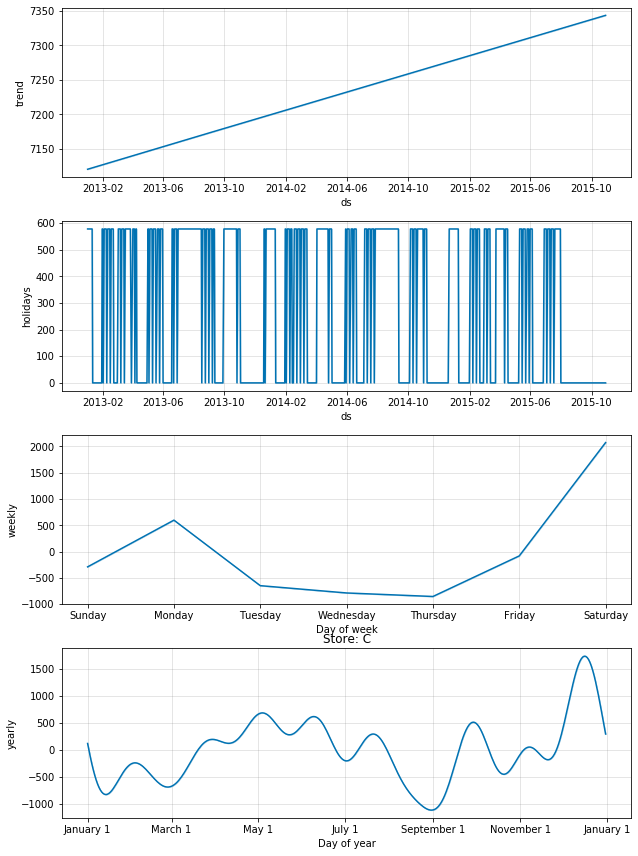

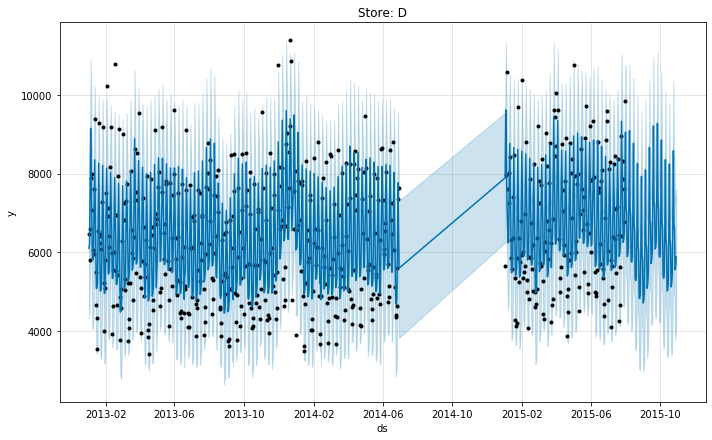

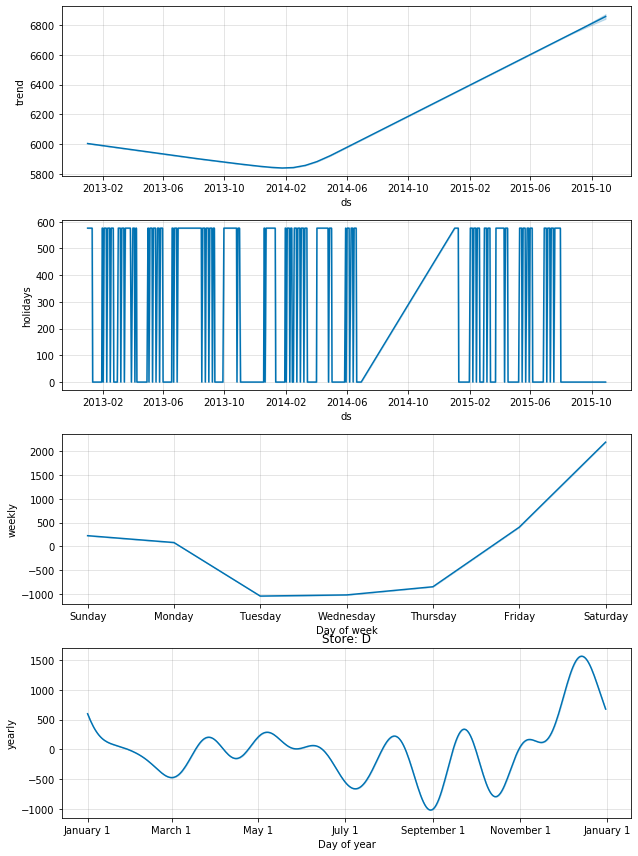

In [21]:
# predictions and plotting
preds = {}
for x in ['a','b','c','d']:
    model=Prophet(interval_width=0.9,holidays = h[x])
    model.fit(dfs[x])

    future = model.make_future_dataframe(periods=90)
    
    # preds
    preds[x] = model.predict(future)
    
    # plots
    f=model.plot(preds[x])
    ax1=f.gca()
    ax1.set_title('Store: '+str(x).upper())
    c=model.plot_components(preds[x])
    ax2=c.gca() 
    ax2.set_title('Store: '+str(x).upper())